# 🧪 LAB 1
# De Machine Learning a Deep Learning  
### Dataset: Breast Cancer (Wisconsin)

---
## 🎯 Objetivo
Demostrar experimentalmente que:

> Una regresión logística es exactamente una neurona con activación sigmoide.

Este laboratorio marca la transición formal entre Machine Learning clásico y Deep Learning.


## 1️⃣ Setup

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Using GPU?', tf.config.list_physical_devices('GPU'))

Using GPU? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2️⃣ Dataset: Breast Cancer

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

print('Shape:', X.shape)
print('Distribución:', np.bincount(y))
print('Clases:', data.target_names)

Shape: (569, 30)
Distribución: [212 357]
Clases: ['malignant' 'benign']


### 🔎 Stop & Think #1
1. ¿Es un problema lineal o no lineal?
2. ¿Cuántas features tiene?
3. ¿Está balanceado el dataset?


## 3️⃣ Train / Validation / Test Split

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20,
    random_state=SEED, stratify=y_trainval
)

## 4️⃣ Escalado

In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

### 🔎 Stop & Think #2
¿Por qué el escalado es importante cuando usamos descenso por gradiente?


## 5️⃣ Modelo ML clásico: Logistic Regression

In [8]:
sk_model = LogisticRegression(max_iter=2000, random_state=SEED)
sk_model.fit(X_train_s, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [9]:
def eval_model(model, X, y):
    proba = model.predict_proba(X)[:,1]
    pred = (proba >= 0.5).astype(int)
    return {
        'Accuracy': accuracy_score(y,pred),
        'Precision': precision_score(y,pred),
        'Recall': recall_score(y,pred),
        'F1': f1_score(y,pred),
        'AUC': roc_auc_score(y,proba)
    }

sk_test = eval_model(sk_model, X_test_s, y_test)
sk_test

{'Accuracy': 0.9824561403508771,
 'Precision': 0.9861111111111112,
 'Recall': 0.9861111111111112,
 'F1': 0.9861111111111112,
 'AUC': np.float64(0.9957010582010581)}

## 6️⃣ Modelo Deep Learning: Una sola neurona (Keras)

In [21]:
keras_model = keras.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(10, activation='sigmoid'), # Añado una layer adicional para testear el resultado
    layers.Dense(1, activation='sigmoid')
])

keras_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
keras_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.AUC(name='auc')
    ]
)

In [23]:
history = keras_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=64,
    verbose=0
)

In [24]:
def eval_keras(model, X, y):
    proba = model.predict(X, verbose=0).reshape(-1)
    pred = (proba >= 0.5).astype(int)
    return {
        'Accuracy': accuracy_score(y,pred),
        'Precision': precision_score(y,pred),
        'Recall': recall_score(y,pred),
        'F1': f1_score(y,pred),
        'AUC': roc_auc_score(y,proba)
    }

keras_test = eval_keras(keras_model, X_test_s, y_test)
keras_test

{'Accuracy': 0.9473684210526315,
 'Precision': 0.9852941176470589,
 'Recall': 0.9305555555555556,
 'F1': 0.9571428571428572,
 'AUC': np.float64(0.9943783068783069)}

## 7️⃣ Comparación de Pesos

In [31]:
sk_w = sk_model.coef_.reshape(-1)
sk_b = sk_model.intercept_[0]

kw, kb = keras_model.layers[0].get_weights()
kw = kw.reshape(-1)
kb = kb[0]

# print('Corr(w):', np.corrcoef(sk_w, kw)[0,1])
# print('MAE(w):', np.mean(np.abs(sk_w - kw)))

## 📈 Visualizaciones

En esta sección añadimos dos visualizaciones clave para comparar modelos y entender el entrenamiento:

- **Curvas ROC** (Scikit-Learn vs Keras)
- **Curvas de entrenamiento** (loss y AUC en train/val)


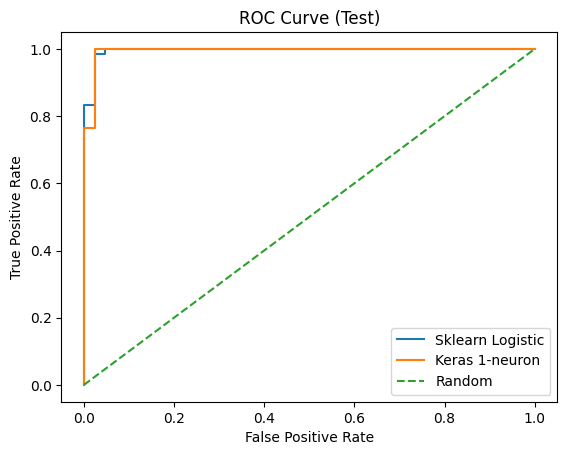

In [32]:
# Probabilidades en test (necesarias para ROC)
sk_proba_test = sk_model.predict_proba(X_test_s)[:, 1]
keras_proba_test = keras_model.predict(X_test_s, verbose=0).reshape(-1)

# Curvas ROC
fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_proba_test)
fpr_ks, tpr_ks, _ = roc_curve(y_test, keras_proba_test)

plt.figure()
plt.plot(fpr_sk, tpr_sk, label='Sklearn Logistic')
plt.plot(fpr_ks, tpr_ks, label='Keras 1-neuron')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend()
plt.show()

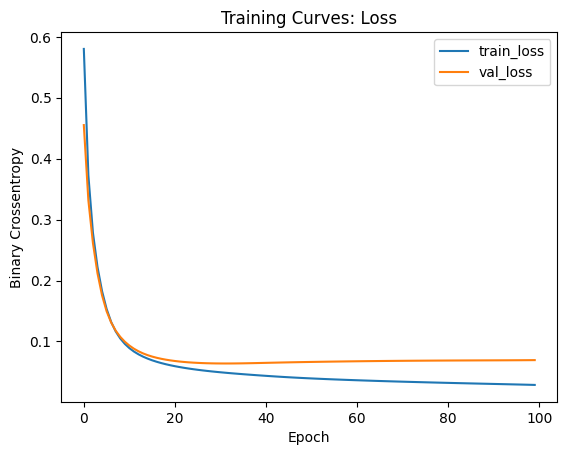

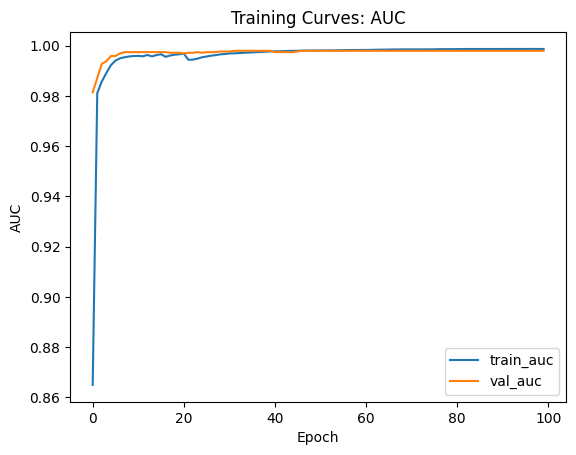

In [33]:
# Curvas de entrenamiento (Keras)
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Training Curves: Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training Curves: AUC')
plt.legend()
plt.show()

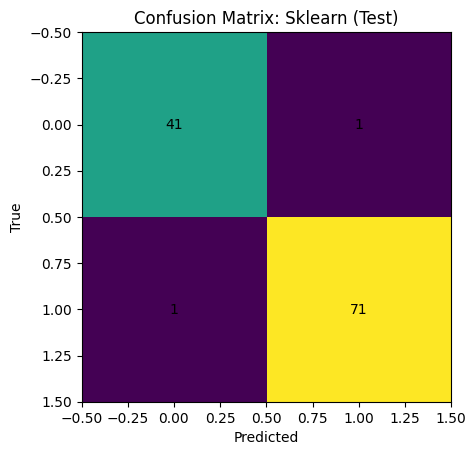

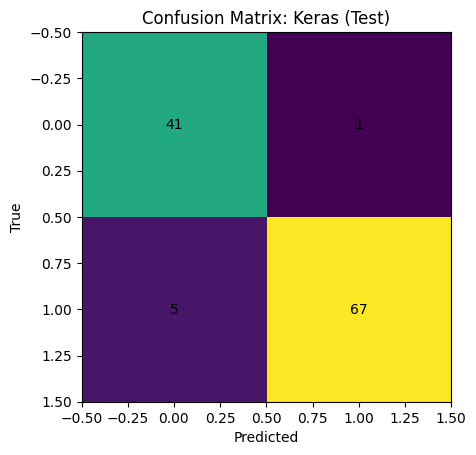

In [34]:
# Matrices de confusión (umbral 0.5)
sk_pred_test = (sk_proba_test >= 0.5).astype(int)
keras_pred_test = (keras_proba_test >= 0.5).astype(int)

cm_sk = confusion_matrix(y_test, sk_pred_test)
cm_ks = confusion_matrix(y_test, keras_pred_test)

fig, ax = plt.subplots()
im = ax.imshow(cm_sk)
ax.set_title('Confusion Matrix: Sklearn (Test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for (i, j), v in np.ndenumerate(cm_sk):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(cm_ks)
ax.set_title('Confusion Matrix: Keras (Test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for (i, j), v in np.ndenumerate(cm_ks):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

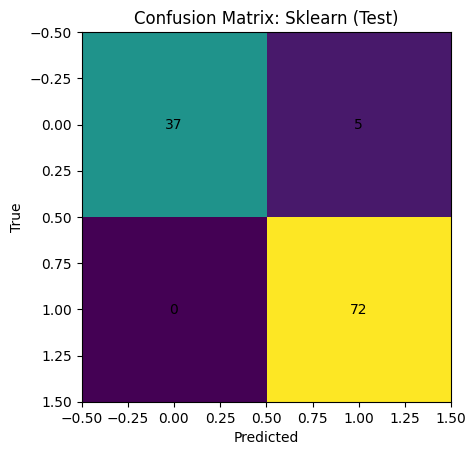

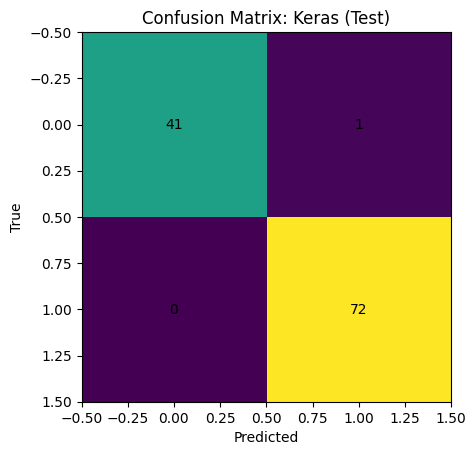

In [35]:
# Matrices de confusión (umbral 0.1)
sk_pred_test = (sk_proba_test >= 0.1).astype(int)
keras_pred_test = (keras_proba_test >= 0.1).astype(int)

cm_sk = confusion_matrix(y_test, sk_pred_test)
cm_ks = confusion_matrix(y_test, keras_pred_test)

fig, ax = plt.subplots()
im = ax.imshow(cm_sk)
ax.set_title('Confusion Matrix: Sklearn (Test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for (i, j), v in np.ndenumerate(cm_sk):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(cm_ks)
ax.set_title('Confusion Matrix: Keras (Test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for (i, j), v in np.ndenumerate(cm_ks):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

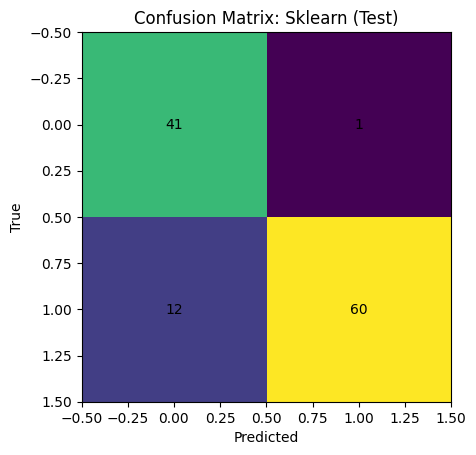

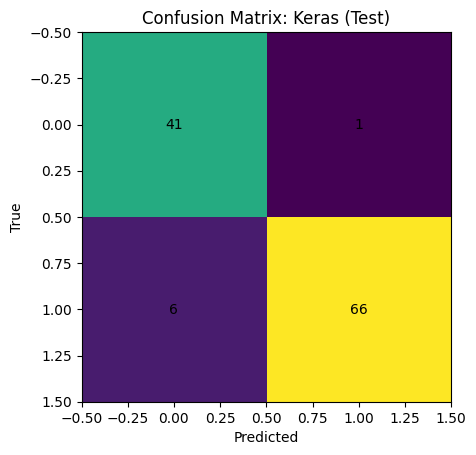

In [36]:
# Matrices de confusión (umbral 0.9)
sk_pred_test = (sk_proba_test >= 0.9).astype(int)
keras_pred_test = (keras_proba_test >= 0.9).astype(int)

cm_sk = confusion_matrix(y_test, sk_pred_test)
cm_ks = confusion_matrix(y_test, keras_pred_test)

fig, ax = plt.subplots()
im = ax.imshow(cm_sk)
ax.set_title('Confusion Matrix: Sklearn (Test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for (i, j), v in np.ndenumerate(cm_sk):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(cm_ks)
ax.set_title('Confusion Matrix: Keras (Test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for (i, j), v in np.ndenumerate(cm_ks):
    ax.text(j, i, str(v), ha='center', va='center')
plt.show()

## 📝 Mini-Quiz Final
1. ¿Por qué la pérdida es convexa en este caso?
2. ¿Qué añadirías para que dejara de ser equivalente a regresión logística?
3. ¿Por qué en DL es trivial añadir capas y en sklearn no?
